# FAPS and Colony2

Tom Ellis, May 2017

In [1]:
import numpy as np
import pandas as pd
from faps import *
from time import time
from ipywidgets import FloatProgress
from IPython.display import display
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The most sophisticated software for sibship reconstruction at present is Colony 2. To allow direct comparison between FAPS and Colony2, this code generates half-sib arrays of four families each of five offspring, using adult populations between 100 and 2000. I used 50 SNP loci, with a haploid error rate of 0.0015. For each family generated it performs sibship reconstruction using FAPS, and also saves the data to be exported to Colony2. Generating the data is quick.

In [2]:
# directory to save output to.
fpath = "/home/thoel507/Documents/Antirrhinum/colonysims_longruns//"

#=======================#
# Simulation parameters #
#=======================#
nloci    = [50]       # number of SNP loci to simulate.
ndads    = [100, 250, 500, 1000, 2000] # list of numbers of dads to subset
fsg_size = 5                           # number of full-siblings per family
nreps    = 300                         # number of half sibships to create for each replicate.
mu       = [0.0015] # real haploid genotyping error rate.

np.random.seed(1308)
nsims = nreps * len(nloci) * len(mu) * len(ndads) # total number of simulations
data_table      = np.zeros([nsims, 14])           # empty table for summary statistics.

t0 = time()
counter = 0
#progsteps = np.arange(0, nreps, float(nreps)/10)[1:]
fp = FloatProgress(min=0, max=nreps) # instantiate the bar
display(fp) # display the bar

for r in range(nreps):
    for n in range(len(ndads)):
        for e in range(len(mu)):
            for l in range(len(nloci)):
                #==============================#
                # generate parents and progeny #
                #==============================#
                # individuals to mate
                dam      = 0
                sires    = range(1,5)
                # generate a base population, and simulate a sibship array.
                allele_freqs = np.random.uniform(0.25,0.5, nloci[l])
                adults = make_parents(ndads[n], allele_freqs) # plus one accounts for the mother
                progeny = make_sibships(adults, dam, sires, fsg_size)

                # Add genotyping errors and dropouts to the genotype data.
                adults = adults.mutations(mu[e])
                progeny = progeny.mutations(mu[e])
                # subset geneotype data for the mothers.
                mothers = adults.subset([0])
                # save the true partition for later.
                true_part = progeny.true_partition()

                #===============#
                # FAPS analysis #
                #===============#
                t1 = time()
                patlik  = paternity_array(progeny, mothers, adults, adults.allele_freqs(), mu[e], selfing_rate=0)
                sc = sibship_clustering(patlik)
                t2 = time()
                # Export to data table
                these_data = np.array([int(counter), int(r), int(nloci[l]), int(ndads[n]), mu[e], # simulation parameters
                                       t1-t2 # time for analysis
                                       ])
                these_data = np.append(these_data, sc.accuracy(progeny, adults))
                data_table[counter] = these_data
                counter += 1
                #====================#
                # Colony2 parameters #
                #====================#
                project_name    = 'input_n'+str(ndads[n]) + '_r'+str(r) + '_i'+str(counter) #Dataset name
                file_path       = fpath
                output_name     = 'output_n'+str(ndads[n]) + '_r'+str(r) + '_i'+str(counter)  #Output file name
                seed            = int(np.random.choice(np.arange(1000), 1))  # Seed for Colony
                update_af       = 0           # 0/1=Not updating/updating allele frequency
                two_sexes       = 2           # 2/1=Dioecious/Monoecious species
                inbreeding      = 0           # 0/1=No inbreeding/inbreeding
                haplodiploid    = 0           # 0/1=Diploid species/HaploDiploid species
                polygamy        = [1,1]       # 0/1=Polygamy/Monogamy for males and females
                infer_clones    = 0           # 0/1=Clone inference =No/Yes
                size_scaling    = 1           # 0/1=Full sibship size scaling =No/Yes
                sibship_prior   = [0,1.0,1.0] # 0,1,2,3=No,weak,medium,strong sibship size prior; mean paternal & maternal sibship size
                known_allele_fr = 1           # 0/1=Unknown/Known population allele frequency
                nruns           = 1           # Number of runs
                run_length      = 2           # Length of run
                monitor_method  = 0           # 0/1=Monitor method by Iterate#/Time in second
                monitor_interval= 100000      # Monitor interval in Iterate# / in seconds
                windows_gui     = 0           # 0/1 running in Windows GUI version?
                analysis_method = 0           # 0/1/2 pairwise-likelihood score (PLS), full likelihood (FL), or the FL and PLS combined (FPLS) method.
                precision       = 3           # 1/2/3=low/medium/high Precision for Fulllikelihood
                # dropout and error rates for each locus
                dropout_rates   = sum((adults.geno == -9)[:,0]).astype('float') / adults.size
                error_rates     = np.repeat(mu[e], progeny.nloci)
                parents_present = [1,1]       # prob. of dad/mum included in the candidates
                # Lists of the names of known fathers
                known_dads      = np.repeat('NA', progeny.size)           
                known_mums      = progeny.mothers
                # Export data to Colony2 format
                export_to_colony(progeny, mothers, adults, allele_freqs,
                                 file_path, project_name, output_name, seed, dropout_rates, error_rates,
                                 known_dads, known_mums, update_af = 0, two_sexes = 1, inbreeding = 0,
                                 haplodiploid= 0, polygamy = [0,0], infer_clones = 0, size_scaling = 1,
                                 sibship_prior   = [0,1.0,1.0], known_allele_fr = 1, nruns = 1,
                                 run_length, monitor_method  = 0, monitor_interval= 100000,
                                 windows_gui = 0, analysis_method = 0,precision = 3, parents_present = [1,1], 
                                 n_incompatibilies=3)
    fp.value += 1 # signal to increment the progress bar

print "All simulations completed after {} minutes.".format(round((time() - t0) / 60, 2))        

All simulations completed after 14.13 minutes.


In [12]:
# save to disk.         
header=['counter','rep','nloci','ndads','mu','time', 'partition_found','delta_loglik','nfamilies',
         'acc_fs','acc_hs','acc_all','prob_sires','prob_absent']
data_table = pd.DataFrame(data_table, columns=header, )
data_table.to_csv('./simulations/colony_comparison.csv', index=False)

Colony can be called for each file using the following command from a UNIX terminal. This took 4h 10min on my Linux machine.

* **Linux:** `for file in *.dat; do ./colony2s.ifort.out IFN:$file; done`

* **Mac:** `for file in *.dat; do ./colony2s.out IFN:$file; done`

Using longer runs and fewer reps this took 14.75 hours (885m16.065s).

For each replicate this code locates the relevant Colony2 output file, determines the maximum-likelihood partition structure, and pulls out information about accuracy of sibship reconstruction.

In [3]:
import glob
# filenames containing ML partitions
filenames = glob.glob('/home/thoel507/Documents/Antirrhinum/colony_sims/*.BestFSFamily')

# dataframe to store information about the Colony analyses.
colony_acc = np.zeros([len(filenames), 6])
# Number of dads and replicate number for each dataset.
colony_acc[:,0] = [filenames[f].split('_n')[1].split('_r')[0] for f in range(len(filenames))] 
colony_acc[:,1] = [filenames[f].split('_r')[1].split('_i')[0] for f in range(len(filenames))] 

partitions = [] # empty list to store ML partitions.
# loop across each file and extract partition structure.
for filename in filenames:
    with open(filename) as f:
        data = f.readlines() # open file
        # extract families
        l = []
        for line in data[1:]:
            words = line.split()          # split each line into columns.
            l = l + [words[3].split(',')] # split the list of offspring names.
        # Label family groups
        y = []
        for i in range(len(l)):
            y = y + [i for x in range(len(l[i]))] # label individuals in each sibship by a common label.
        partitions = partitions + [y] # append to partitions

# Assess accuracy of sibship partitioning.
from relation_matrix import relation_matrix
from partition_accuracy import partition_accuracy

true_part = np.array([0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]) # the true partition structure for each family
# Accuracies of relationship reconstructions
for p in range(len(partitions)):
    colony_acc[p,2] = partition_accuracy(true_part, partitions[p], 'all')
    colony_acc[p,3] = partition_accuracy(true_part, partitions[p], 'fs')
    colony_acc[p,4] = partition_accuracy(true_part, partitions[p], 'hs')
    colony_acc[p,5] = len(np.unique(partitions[p]))

header='ndads,rep,acc_all,acc_fs,acc_hs,nfamilies'
#np.savetxt('./simulations/colony_accuracy.csv', colony_acc, delimiter=',', fmt="%5.4f", comments='', header=header)


Reimport the data tables if you are returning to this data set, and get the means for simulations for each level of the number of candidate fathers.

In [17]:
import pandas as pd
# import tables on accuracies
colony_acc  = pd.read_csv('./simulations/colony_accuracy.csv')
faps_acc = pd.read_csv('./simulations/colony_comparison.csv')
# get means for each number of fathers. 
cv = colony_acc.groupby('ndads').mean()
fv = faps_acc.groupby('ndads').mean()

In [18]:
abs(faps_acc.time).sum()

100.67474961280439

To compare the two approaches we can plot the how well they reconstruct relationships between true full- and half- sibs. For FAPS (solid lines) this is averaged over possible partition structures. For Colony2 (dashed lines), this is based on the maximum likelihood estimate. The first plot shows that both methods reconstruct full-sib relationships with near 100% accuracy for the parameters considered. However, Colony2 has low accuracy for half-sib relationships (i.e. true half-sibs tend to be grouped together into full sibships).

Plotting the distribution of family sizes shows the same thing. FAPS (solid lines) returns ML partitions with four families with high probability. In contrast,  Colony2 (dashed lines)is most likely to return a single family with all individuals assigned to the same family.

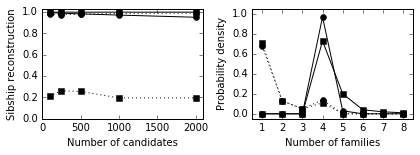

In [21]:
ndads = [100, 250, 500, 1000, 2000] # list of numbers of dads to subset
plotcodes1 = [':ok',':*k',':^k',':Dk',':sk']
plotcodes2 = ['-ok','-*k','-^k','-Dk','-sk']

fig = plt.figure(figsize=(16.9/2.54,5/2.54))
fig.subplots_adjust(wspace=0.3, hspace=0.1)

ax = fig.add_subplot(1,2,1)
ax.set_xlim(0, 2100)
ax.set_ylim(0, 1.03)
ax.set_xlabel('Number of candidates')
ax.set_ylabel('Sibship reconstruction')
ax.plot(ndads, fv.acc_fs, '-ok', label='Full-sib relationships')
ax.plot(ndads, fv.acc_hs, '-sk', label='Half-sib relationships')
#ax.plot(ndads, fv.acc_all_faps, '-^k', label=' siblings')
#ax.legend(loc='best')
ax.plot(ndads, cv.acc_fs, ':ok')
ax.plot(ndads, cv.acc_hs, ':sk')
#ax.plot(ndads, cv.acc_all_col, ':^k')
#ax.grid(axis='y')

#vp = fig.add_subplot(1,3,2)
#ax.set_xlim(0, 2100)
#vp.set_ylim(-0.03, 1.03)
#vp.set_xlim(0.5, 4.5)
#vp.set_ylabel('Accuracy of reconstruction')
#vp.set_xticks([1.5,3.5])
#vp.set_xticklabels(['FAPS','Colony2'])
#refn = 250
#acc250 = [faps_acc.acc_fs[  faps_acc.ndads   == refn],
 #         faps_acc.acc_hs[  faps_acc.ndads   == refn],
  #        colony_acc.acc_fs[colony_acc.ndads == refn],
   #       colony_acc.acc_hs[colony_acc.ndads == refn]]
#bp = vp.violinplot(acc250, showextrema=False)
#bp['bodies'][0].set_facecolor('white')
#bp['bodies'][1].set_facecolor('k')
#bp['bodies'][2].set_facecolor('white')
#bp['bodies'][3].set_facecolor('k')
#for pc in bp['bodies']:
#    pc.set_edgecolor('k')
#    pc.set_alpha(0.5)
#vp.grid(axis='y')

hst = fig.add_subplot(1,2,2)
#hst.hist(nfamilies, np.arange(0.5, 6.5, 1), normed=True, color='gray')
hst.set_xlabel('Number of families')
hst.set_ylabel('Probability density')
hst.set_xlim(0.5, 8.5)
hst.set_ylim(-0.05, 1.05)
for i in [0,4]:
    hst.plot(range(1,9), np.histogram(faps_acc.nfamilies[ faps_acc.ndads ==  ndads[i]], bins=range(1,10), normed=True)[0], plotcodes2[i], label=ndads[i])
#hst.legend(loc='best')
for i in [0,4]:
    hst.plot(range(1,9), np.histogram(colony_acc.nfamilies[colony_acc.ndads==ndads[i]], bins=range(1,10), normed=True)[0], plotcodes1[i])
#hst.grid(axis='y')

plt.savefig('./figures/colony2.eps', bbox_inches='tight', pad_inches=0.1)